# Selection Diagrams

This notebook is for creating diagrams of how selection works, based on *real* data from the yt sample datasets.

We'll construct and highlight diagrams showing selection of:

 * Slices
 * Regions
 * Spheres
 
This should be straightforward since we can use the built-in yt selection routines.

In [50]:
import drawSvg as draw
import yt
import numpy as np
import ipywidgets

In [7]:
#ds = yt.load("~/data/IsolatedGalaxy/galaxy0030/galaxy0030")
#ds = yt.load("/home/matthewturk/data/EnzoKelvinHelmholtz/DD0011/DD0011")
#ds = yt.load("/home/matthewturk/data/PopIII_mini/DD0034/DD0034")
ds = yt.load("/home/matthewturk/data/enzo_tiny_cosmology/DD0046/DD0046")

yt : [INFO     ] 2020-03-03 11:42:38,077 Parameters: current_time              = 230.66527489234
yt : [INFO     ] 2020-03-03 11:42:38,081 Parameters: domain_dimensions         = [32 32 32]
yt : [INFO     ] 2020-03-03 11:42:38,082 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2020-03-03 11:42:38,083 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2020-03-03 11:42:38,084 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2020-03-03 11:42:38,085 Parameters: current_redshift          = -2.7810863612032e-09
yt : [INFO     ] 2020-03-03 11:42:38,086 Parameters: omega_lambda              = 0.727
yt : [INFO     ] 2020-03-03 11:42:38,087 Parameters: omega_matter              = 0.273
yt : [INFO     ] 2020-03-03 11:42:38,088 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2020-03-03 11:42:38,098 Parameters: hubble_constant           = 0.702


In [8]:
s = ds.sphere("c", 0.5)

Parsing Hierarchy : 100%|██████████| 211/211 [00:00<00:00, 5665.04it/s]
yt : [INFO     ] 2020-03-03 11:42:39,254 Gathering a field list (this may take a moment.)


In [62]:
frb = ds.r[:].integrate("density", axis="z").to_frb(1.0, (512, 512))
image_data = yt.write_bitmap(yt.write_image(np.log10(frb["density"].v[:,::-1]), None), None)
ipywidgets.Image(value = image_data)

yt : [INFO     ] 2020-03-03 11:56:37,555 Projection completed
yt : [INFO     ] 2020-03-03 11:56:37,559 Making a fixed resolution buffer of (density) 512 by 512


Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x02\x00\x00\x00\x02\x00\x08\x06\x00\x00\x00\xf4x\xd4…

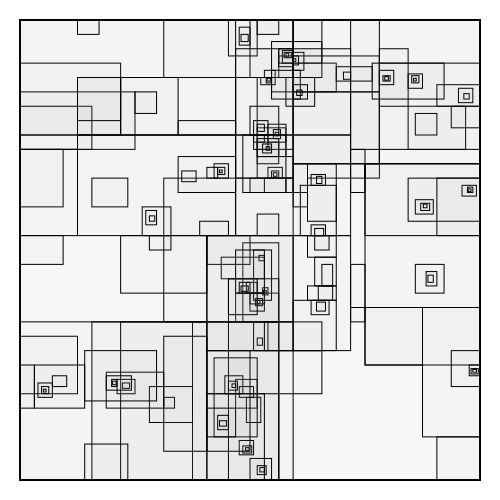

In [26]:
xax = 0
yax = 1
margin = 20
width = height = 500
c = draw.Drawing(width = width, height = height)
scale_x = lambda v: margin + (width - 2*margin) * v
scale_y = lambda v: margin + (height - 2*margin) * v
domain = draw.Rectangle(scale_x(0), scale_y(0),
                        scale_x(1.0) - scale_x(0.0),
                        scale_y(1.0) - scale_y(0.0),
                        fill = 'none', stroke_width=2.0,
                        stroke = 'black')
c.append(domain)
for grid in ds.index.grids:
    if grid.Level > 5: continue
    LE = grid.LeftEdge.v
    RE = grid.RightEdge.v
    grid_outline = draw.Rectangle(
        scale_x(LE[xax]),
        scale_y(LE[yax]),
        scale_x(RE[xax]) - scale_x(LE[xax]),
        scale_y(RE[yax]) - scale_y(LE[yax]),
        fill = '#AAAAAA', fill_opacity=0.05, stroke = 'black', stroke_width=1.0)
    c.append(grid_outline)
display(c)